In [1]:
from itertools import product, combinations
from collections import Counter
import math
import base64
import io
import json
from pathlib import Path
from collections import Counter
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import torch
import Levenshtein
from tensorboard.backend.event_processing import event_accumulator
from plotnine import *
import numpy as np
import random
import magicsoup as ms
from e1_co2_fixing.chemistry import CHEMISTRY, ESSENTIAL_MOLS

theme_set(theme_minimal())
THIS_DIR = Path(".") / "e1_co2_fixing"
RUN_NAME = "2023-04-27_14-40_0"
RUN_DIR_ROOT = THIS_DIR / "runs"
RUN_DIR = RUN_DIR_ROOT / RUN_NAME

# Run 2023-04-27_14-40


In [2]:
with open(RUN_DIR / "hparams.json") as fh:
    hparams = json.load(fh)
hparams

{'molmap_init': 20.0,
 'n_init_gens': 100.0,
 'n_adapt_gens': 1000.0,
 'mut_scheme': 'linear',
 'split_ratio': 0.2,
 'split_thresh_cells': 0.6,
 'split_thresh_mols': 0.4,
 'init_enzymes': False}

In [3]:
scalars = [
    ("Cells/total", "cells"),
    ("Cells/Generation", "generation"),
    ("Cells/Survival", "survival"),
    ("Molecules/CO2[ext]", "CO2[e]"),
    ("Molecules/CO2[int]", "CO2[i]"),
    ("Molecules/E[ext]", "E[e]"),
    ("Molecules/E[int]", "E[i]"),
    ("Molecules/X[ext]", "X[e]"),
    ("Molecules/X[int]", "X[i]"),
    ("Other/Split", "split")
]

records = []
for tf_event_file in RUN_DIR.glob("*.out.tfevents.*"):
    tf_ea = event_accumulator.EventAccumulator(str(tf_event_file))
    tf_ea.Reload()
    for tag, label in scalars:
        for obj in tf_ea.Scalars(tag):
            records.append({
                "scalar": label,
                "value": obj.value,
                "step": obj.step,
            })
scalars_df = pd.DataFrame.from_records(records)

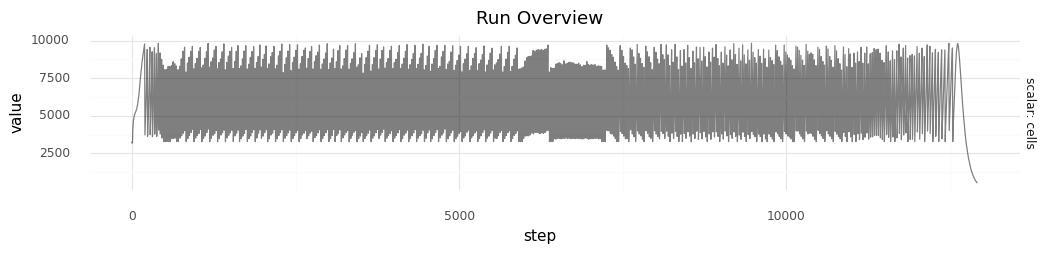

<ggplot: (8761055402816)>

In [4]:
(ggplot(scalars_df[scalars_df["scalar"] == "cells"])
    + geom_line(aes(y="value", x="step"), alpha=0.5)
    + facet_grid("scalar ~ .", scales="free", labeller="label_both")
    + theme(figure_size=(12, 2))
    + ggtitle("Run Overview"))

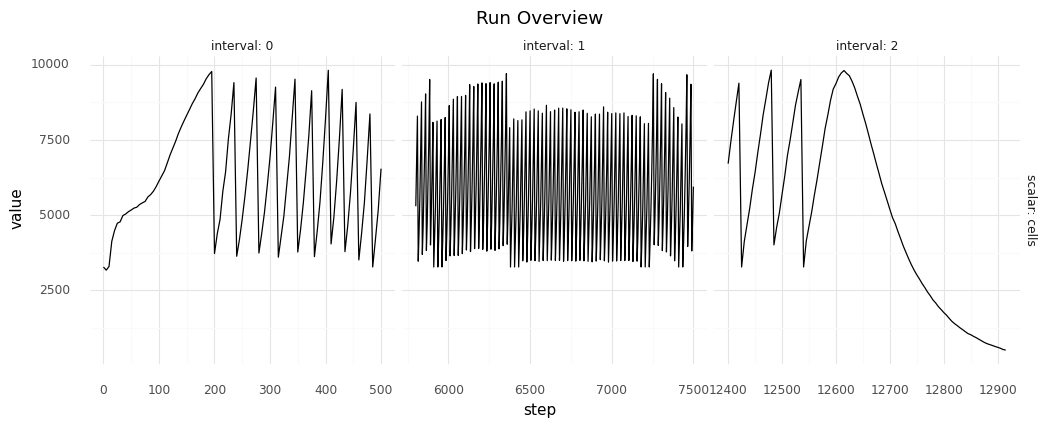

<ggplot: (8761050254976)>

In [22]:
vars = ["cells", "generation"]
intervals = [
    (0, 500),
    (5_800, 7_500),
    (12_400, 99999),
]

scalars_df["interval"] = -1
for i, (a, b) in enumerate(intervals):
    scalars_df.loc[(scalars_df["step"] >= a) & (scalars_df["step"] <= b), "interval"] = i

(ggplot(scalars_df[scalars_df["scalar"].isin(vars) & (scalars_df["interval"] >= 0)])
    + geom_line(aes(y="value", x="step"))
    + facet_grid("scalar ~ interval", scales="free", labeller="label_both")
    + theme(figure_size=(12, 4))
    + ggtitle("Run Overview"))

In [7]:
# extract splits
df = scalars_df.loc[scalars_df["scalar"] == "split"]
splits_df = df.loc[df["value"].diff(periods=1) > 0.0, ["step"]]
scalars_df = scalars_df[scalars_df["scalar"] != "split"]

# map generations
gens = scalars_df.loc[scalars_df["scalar"] == "generation", ["value", "step"]]
gens = gens.rename(columns={"value": "generation"})
scalars_df = scalars_df.merge(gens, on="step")
scalars_df = scalars_df[scalars_df["scalar"] != "generation"]

# label molecules
scalars_df["label"] = [d.split("[")[0] for d in scalars_df["scalar"]]
scalars_df["label"] = pd.Categorical(scalars_df["label"], categories=["cells", "CO2", "E", "X"])
scalars_df["localization"] = ""
scalars_df.loc[[d.endswith("[i]") for d in scalars_df["scalar"]], "localization"] = "int"
scalars_df.loc[[d.endswith("[e]") for d in scalars_df["scalar"]], "localization"] = "ext"

In [60]:
vars = ["cells", "CO2[i]", "CO2[e]", "E[i]", "E[e]", "X[i]", "X[e]"]
df = scalars_df[scalars_df["scalar"].isin(vars)].copy()

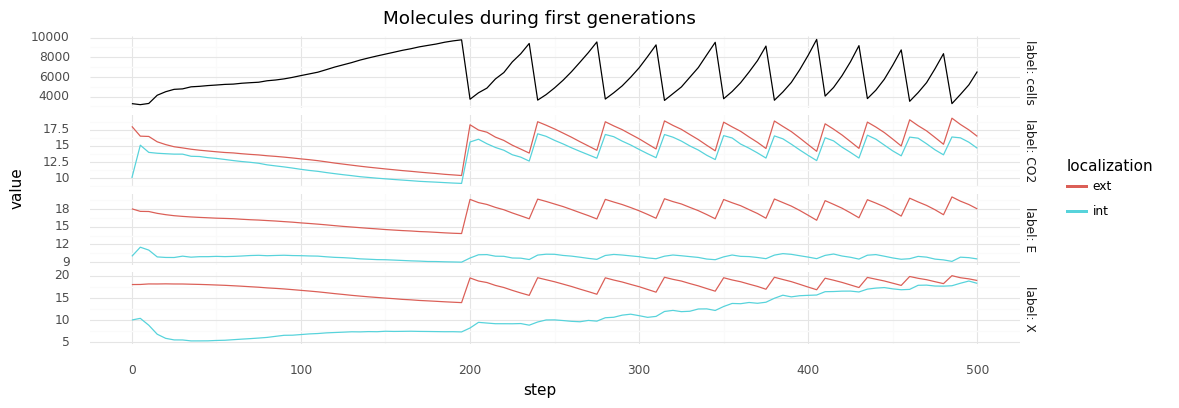

<ggplot: (8761055283140)>

In [62]:
int_mask = df["interval"] == 0
cell_mask = df["scalar"] == "cells"
nocell_mask = df["scalar"] != "cells"

(ggplot(df)
    + geom_line(aes(y="value", x="step", color="localization"), df[int_mask & nocell_mask])
    + geom_line(aes(y="value", x="step"), data=df[int_mask & cell_mask])
    + facet_grid("label ~ .", scales="free_y", labeller="label_both")
    + theme(figure_size=(12, 4))
    + ggtitle("Molecules during first generations"))

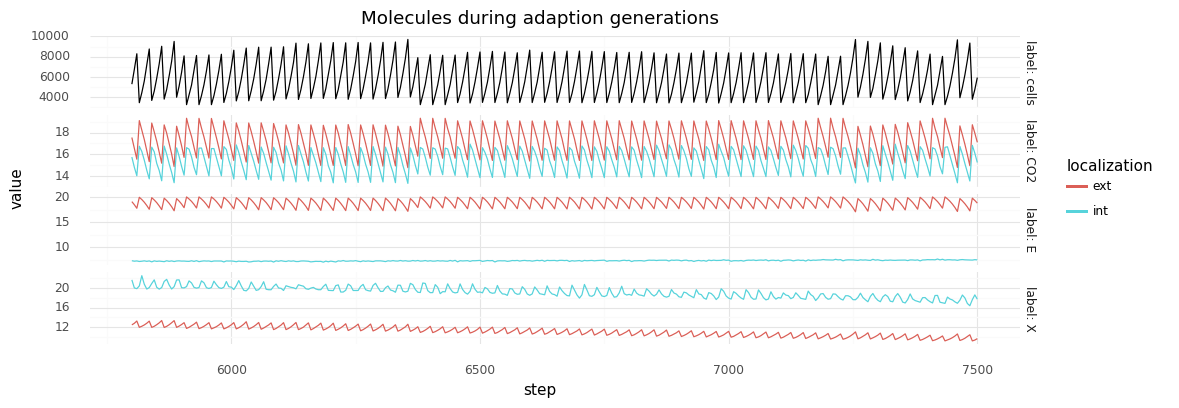

<ggplot: (8761049907050)>

In [63]:
int_mask = df["interval"] == 1
cell_mask = df["scalar"] == "cells"
nocell_mask = df["scalar"] != "cells"

(ggplot(df)
    + geom_line(aes(y="value", x="step", color="localization"), df[int_mask & nocell_mask])
    + geom_line(aes(y="value", x="step"), data=df[int_mask & cell_mask])
    + facet_grid("label ~ .", scales="free_y", labeller="label_both")
    + theme(figure_size=(12, 4))
    + ggtitle("Molecules during adaption generations"))

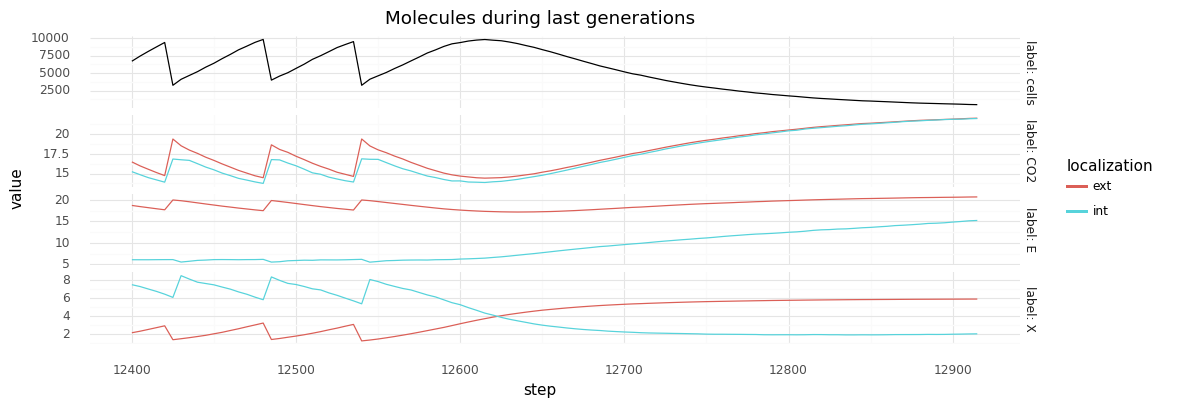

<ggplot: (8761050296420)>

In [61]:
int_mask = df["interval"] == 2
cell_mask = df["scalar"] == "cells"
nocell_mask = df["scalar"] != "cells"

(ggplot(df)
    + geom_line(aes(y="value", x="step", color="localization"), df[int_mask & nocell_mask])
    + geom_line(aes(y="value", x="step"), data=df[int_mask & cell_mask])
    + facet_grid("label ~ .", scales="free_y", labeller="label_both")
    + theme(figure_size=(12, 4))
    + ggtitle("Molecules during last generations"))

In [67]:
def load_img_maps(from_step: int, to_step: int, size=1000) -> dict:
    out = {}
    for tf_event_file in RUN_DIR.glob("*.out.tfevents.*"):
        tf_ea = event_accumulator.EventAccumulator(str(tf_event_file), {"images": size})
        tf_ea.Reload()
        for obj in tf_ea.Images("Maps/Cells"):
            if from_step <= obj.step <= to_step:
                out[obj.step] = obj.encoded_image_string
    return out

In [68]:
def plot_cell_maps(img_maps: dict, title="Cell maps", n_cols=11, w=15, h=1.8):
    steps = sorted(list(img_maps))
    n_rows = math.ceil(len(steps) / n_cols)
    fig, axs = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, figsize=(w, h * n_rows))
    for step, ax in zip(steps, axs.flatten()):
        bimg = io.BytesIO(img_maps[step])
        img = mpimg.imread(bimg, format='JPG')
        ax.imshow(img, interpolation='nearest')
        ax.title.set_text(f"step {step}")
    fig.suptitle(title)
    plt.show()

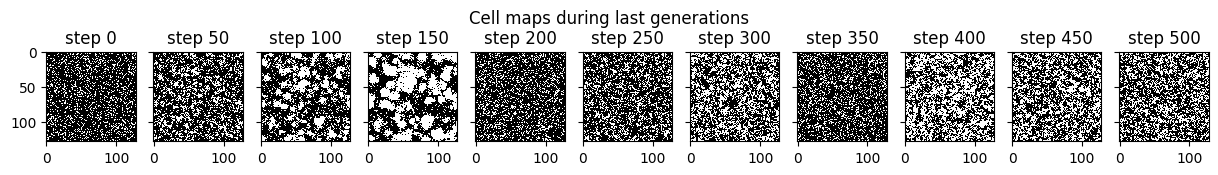

In [70]:
img_maps = load_img_maps(0, 500)
plot_cell_maps(img_maps, title="Cell maps during last generations")

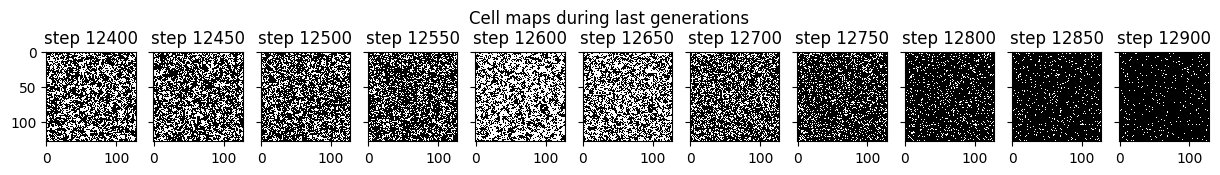

In [69]:
img_maps = load_img_maps(12_400, 13_000)
plot_cell_maps(img_maps, title="Cell maps during last generations")

asd

In [3]:
world = ms.World.from_file(rundir=RUN_DIR_ROOT, device="cpu")

In [4]:
steps_map = {}
for statedir in RUN_DIR.glob("step=*"):
    step = int(statedir.name.split("step=")[-1])
    world.load_state(statedir=statedir, ignore_cell_params=True)
    steps_map[step] = {
        "ls": world.labels.copy(),
        "gs": world.genomes.copy(),
    }

In [14]:
sampling_ratio = 0.1

def entropy(counts: list) -> float:
    a = np.array([d for d in counts if d > 0])
    return np.sum(a * np.log(a))

records = []
for step, obj in steps_map.items():
    #lcounts = Counter(obj["ls"])
    #gcounts = Counter(obj["gs"])
    #ugenomes = list(set(obj["gs"])) 
    #samples = random.sample(ugenomes, k=int(len(ugenomes) * sampling_ratio))
    #dists = [Levenshtein.distance(a, b) for a, b in combinations(samples, 2)]
    records.append({
        "step": step,
        "glen": np.mean([len(d) for d in obj["gs"]])
    })

cells_df = pd.DataFrame.from_records(records)

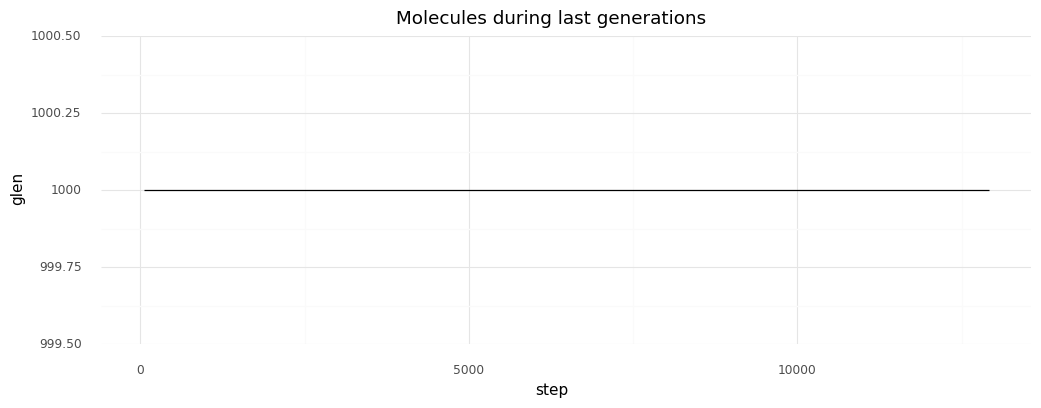

<ggplot: (8727985892328)>

In [15]:
(ggplot(cells_df)
    + geom_line(aes(y="glen", x="step"))
    #+ facet_grid("label ~ .", scales="free_y", labeller="label_both")
    + theme(figure_size=(12, 4))
    + ggtitle("Molecules during last generations"))

In [9]:
steps_of_interest = (1_300, 1_600, 3_000, 5_000, 7_700)
co2_idx = mol_2_idx["CO2"]

records = []
for step in steps_of_interest:
    world.load_state(statedir=RUN_DIR / f"step={step}", update_cell_params=False)
    for x, y in product(range(world.map_size), range(world.map_size)):
        n = world.molecule_map[co2_idx, x, y].item()
        c = float(world.cell_map[x, y].item()) * 100
        records.append({"step": step, "x": x, "y": y, "[x]": n, "shown": "CO2"})
    for cell in world.cells:
        x, y = cell.position
        records.append({"step": step, "x": x, "y": y, "[x]": 0, "shown": "cells"})

df = pd.DataFrame.from_records(records)
df["shown"] = pd.Categorical(df["shown"], categories=["cells", "CO2"])

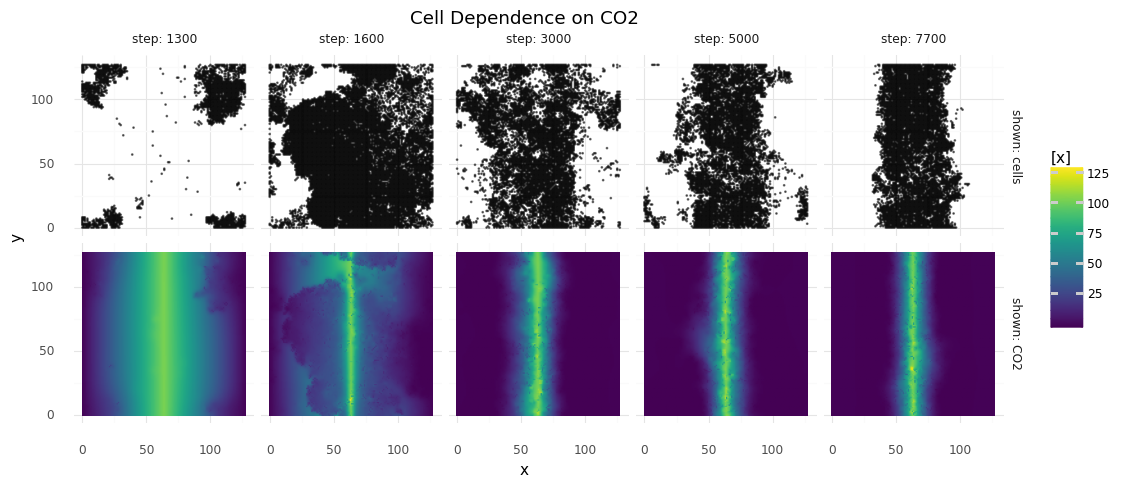

<ggplot: (8791694523898)>

In [10]:
axis_lims = (0, world.map_size)
(ggplot(df, aes(x="x", y="y"))
    + geom_point(data=df[df["shown"] == "cells"], size=.1, alpha=.5)
    + geom_raster(aes(fill="[x]"), data=df[df["shown"] == "CO2"])
    + coord_fixed(ratio=1, xlim=axis_lims, ylim=axis_lims)
    + facet_grid("shown ~ step", labeller="label_both")
    + theme(figure_size=(12, 3))
    + ggtitle("Cell Dependence on CO2"))

## Final Colony

Here, I want to see to what this colony had evolved.
I started with simply comparing their genomes.
Below, I compare all genomes using the Levenstein distance (insertion, deletion, substitution), calculate an affinity from it, and do a spectral clustering.
To reduce processing time, 10% of all cells were sampled.
First, the barplot should just give an overview of the found clusters.

As you can see there are barely any clusters found.
Actually, I tried around with different $\beta$ values for affinity calculation to get the spectral clustering to even find a few more cells outside the main cluster.
These clusters are unstable and very debatable.
One interesting thing to note though is the genome size.
It seems most cells now have a genome size of 4000 (we started with 500).
I should add a term for penalizing large genomes in later simulations.
Proteins and domains per protein are actually expected for these genome sizes.

In [11]:
step = 7_700
world.load_state(statedir=RUN_DIR / f"step={step}")
n_cells = len(world.cells)

In [12]:
sampling_ratio = 0.1

def distance(seq0: str, seq1: str) -> float:
    return Levenshtein.distance(seq0, seq1) / max(len(seq0), len(seq1))

samples = random.sample(range(n_cells), k=int(n_cells * sampling_ratio))
sample_2_cell = {i: d for i, d in enumerate(samples)}
n_samples = len(samples)

D = np.zeros((n_samples, n_samples))
for i, j in combinations(range(n_samples), 2):
    ci = samples[i]
    cj = samples[j]
    a = distance(world.cells[ci].genome, world.cells[cj].genome)
    D[i, j] = a
    D[j, i] = a

In [13]:
def affinity(d: np.ndarray, std: float) -> np.ndarray:
    return np.exp(-0.1 * d / std)

A = affinity(D, D.std())
clustering = SpectralClustering(n_clusters=5, n_init=20, affinity="precomputed").fit(A)

records = []
for sample_i, label in enumerate(clustering.labels_):
    cell = world.cells[sample_2_cell[sample_i]]
    records.append({
        "cluster": label,
        "affinity": A[sample_i].sum(),
        "genome_size": len(cell.genome),
        "proteins": len(cell.proteome),
        "domains": sum(len(d.domains) for d in cell.proteome),
        "cells": 1
    })

df = pd.DataFrame.from_records(records) \
    .groupby("cluster") \
    .sum() \
    .reset_index()

df["affinity"] = df["affinity"] / df["cells"]
df["genome_size"] = df["genome_size"] / df["cells"]
df["proteins"] = df["proteins"] / df["cells"]
df["domains/protein"] = df["domains"] / df["proteins"]

variables = ["cells", "affinity", "genome_size", "proteins", "domains/protein"]
df = df.melt(id_vars=["cluster"], value_vars=variables)
df["variable"] = pd.Categorical(df["variable"], categories=variables)
df["cluster"] = pd.Categorical(df["cluster"], categories=sorted(df["cluster"].unique()))

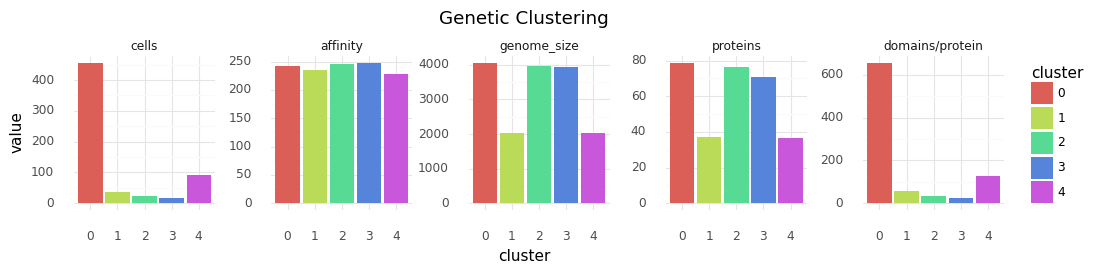

<ggplot: (8791702348279)>

In [14]:
(ggplot(df)
    + geom_col(aes(x="cluster", y="value", fill="cluster"), position="dodge")
    + facet_wrap("~ variable", scales="free", ncol=5)
    + theme(figure_size=(12, 2), subplots_adjust={"wspace": .4, "hspace": .4})
    + ggtitle("Genetic Clustering"))

Below, I am deriving centroids for these clusters.
These are the cells that have on average the highest affinity to all other cells in the same cluster.
Then, all cells are plotted with their affinity to each cluster centroid.
As mentioned above, these clusters are very debatable.
I was hoping to see some location of certain cluster (outskirts of the gradient vs middle) but honestly this is just more or less random.
Maybe I would get better results by calculating affinity based on a Needleman-Wunsch score.
My simulation includes recombinations and the Levenstein distance can't track these.
So basically any recombinations completely obliterates the affinity.

In [15]:
centroids = {}
for cluster in set(clustering.labels_):
    clust_mask = clustering.labels_ == cluster
    samples = [i for i, d in enumerate(clust_mask) if d]
    cis = np.argwhere(clust_mask).flatten()
    centroid = samples[np.argmax(A[cis][:, cis].sum(0))]
    centroids[cluster] = world.cells[sample_2_cell[centroid]]

records = []
for cluster, centroid in centroids.items():
    for ci, cell in enumerate(world.cells):
        records.append({
            "cell_idx": ci,
            "x": cell.position[0],
            "y": cell.position[1],
            "cluster": cluster,
            "d(centroid)": distance(centroid.genome, cell.genome)
        })

df = pd.DataFrame.from_records(records)
df["a(centroid)"] = affinity(df["d(centroid)"], df["d(centroid)"].std())

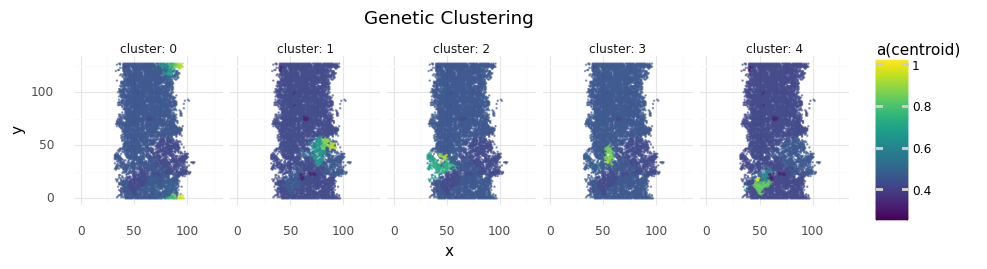

<ggplot: (8791702424378)>

In [16]:
axis_lims = (0, world.map_size)
(ggplot(df)
    + geom_point(aes(x="x", y="y", color="a(centroid)"), size=0.01, alpha=0.5)
    + coord_fixed(ratio=1, xlim=axis_lims, ylim=axis_lims)
    + facet_grid(". ~ cluster", labeller="label_both")
    + theme(figure_size=(10, 3))
    + ggtitle("Genetic Clustering"))

Another approach would be to take a look at the proteomes.
First, I am creating a feature matrix for all cells in which I take note of all the reactions the cell can catalyze, and all the molecule species it can transport.
I tried around with somehow integrating $K_M$ and $V_{max}$ values of domains, but it gets difficult to interpret.
A one-hot encoding of the cells capabilities is straight forward.
Then, I can do a spectral clustering with these features again (affinities are constructed using a radial basis function kernel).

Some cluster-describing bar charts are shown again.
I'm not going to lie, these clusters are pretty anticlimactic.
There is basically one big cluster, and then the other 5%.

In [17]:
proteomes = pd.DataFrame(index=range(n_cells))

def name_reaction(substrates: list[ms.Molecule], products: list[ms.Molecule]) -> str:
    subst = " + ".join(str(d) for d in substrates)
    prods = " + ".join(str(d) for d in products)
    return f"{subst} <-> {prods}"

def name_transporter(molecule: ms.Molecule) -> str:
    return f"transport {molecule}"

for subs, prods in world.genetics.chemistry.reactions:
    proteomes[name_reaction(subs, prods)] = 0
for mol in world.genetics.chemistry.molecules:
    proteomes[name_transporter(mol)] = 0

for cell in world.cells:
    for protein in cell.proteome:
        for dom in protein.domains:
            if dom.is_catalytic:
                name = name_reaction(dom.substrates, dom.products)
            if dom.is_transporter:
                name = name_transporter(dom.substrates[0])
            proteomes.loc[cell.idx, name] = 1

In [18]:
clustering = SpectralClustering(n_clusters=5, n_init=20).fit(proteomes)
A = clustering.affinity_matrix_

records = []
for cell_i, label in enumerate(clustering.labels_):
    cell = world.cells[cell_i]
    records.append({
        "cluster": label,
        "affinity": A[cell_i].sum(),
        "genome_size": len(cell.genome),
        "proteins": len(cell.proteome),
        "domains": sum(len(d.domains) for d in cell.proteome),
        "cells": 1
    })

df = pd.DataFrame.from_records(records) \
    .groupby("cluster") \
    .sum() \
    .reset_index()

df["affinity"] = df["affinity"] / df["cells"]
df["genome_size"] = df["genome_size"] / df["cells"]
df["proteins"] = df["proteins"] / df["cells"]
df["domains/protein"] = df["domains"] / df["proteins"]

variables = ["cells", "affinity", "genome_size", "proteins", "domains/protein"]
df = df.melt(id_vars=["cluster"], value_vars=variables)
df["variable"] = pd.Categorical(df["variable"], categories=variables)
df["cluster"] = pd.Categorical(df["cluster"], categories=sorted(df["cluster"].unique()))

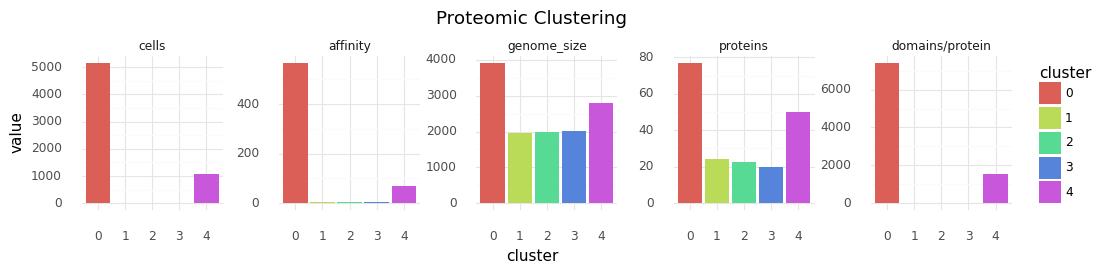

<ggplot: (8791696314615)>

In [19]:
(ggplot(df)
    + geom_col(aes(x="cluster", y="value", fill="cluster"), position="dodge")
    + facet_wrap("~ variable", scales="free", ncol=5)
    + theme(figure_size=(12, 2), subplots_adjust={"wspace": .4, "hspace": .4})
    + ggtitle("Proteomic Clustering"))

As before, I am calculating centroids again and show all cells affinity to them.
But as mentioned above: It's pretty much one cluster and a few odd ones out.
And the odd ones out are not even particularly clustered.

In [20]:
centroids = {}
for cluster in set(clustering.labels_):
    clust_mask = clustering.labels_ == cluster
    cells = [i for i, d in enumerate(clust_mask) if d]
    cis = np.argwhere(clust_mask).flatten()
    centroid = cells[np.argmax(A[cis][:, cis].sum(0))]
    centroids[cluster] = world.cells[centroid]

records = []
for cluster, centroid in centroids.items():
    for ci, cell in enumerate(world.cells):
        records.append({
            "cell_idx": ci,
            "x": cell.position[0],
            "y": cell.position[1],
            "cluster": cluster,
            "a(centroid)": A[centroid.idx, cell.idx]
        })

df = pd.DataFrame.from_records(records)

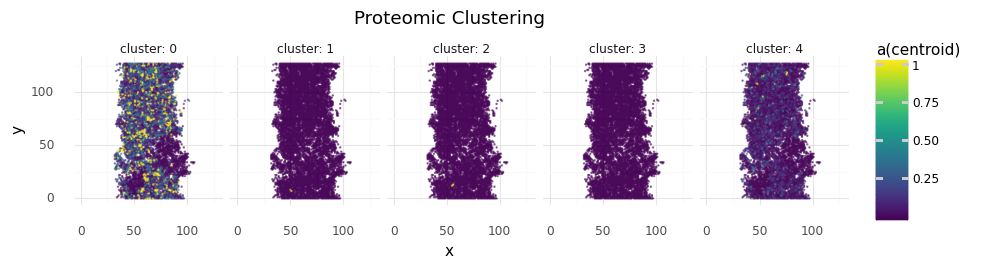

<ggplot: (8791695048692)>

In [21]:
axis_lims = (0, world.map_size)
(ggplot(df)
    + geom_point(aes(x="x", y="y", color="a(centroid)"), size=0.01, alpha=0.5)
    + coord_fixed(ratio=1, xlim=axis_lims, ylim=axis_lims)
    + facet_grid(". ~ cluster", labeller="label_both")
    + theme(figure_size=(10, 3))
    + ggtitle("Proteomic Clustering"))

This made me take a look at the actual proteomes and I think the plot below pretty much explains it.
Almost all cells have all the transporters and catalytic domains there are.
So, these cells just constantly grew their genome and accumulated more and more proteins.
Probably through recombination, every now and then a cell will get a smaller genome, with one or two of these capabilities missing.
These are the cells that show up as different in the clustering above.
I have to be honest, I was hoping for something more clever.
So, in the next run I definitly need to term to penalize large genomes.

In [22]:
df = proteomes.sum(0) \
    .reset_index(name="cell count") \
    .rename(columns={"index": "capability"})

df["type"] = "catalysis"
df.loc[df["capability"].str.startswith("transport"), "type"] = "transport"

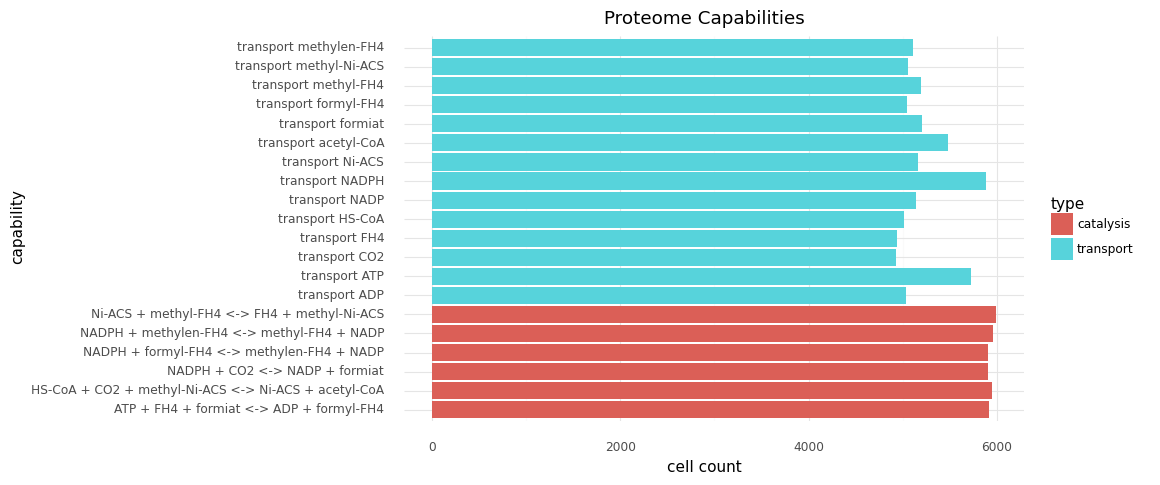

<ggplot: (8791665447566)>

In [23]:
(ggplot(df)
    + geom_col(aes(x="capability", y="cell count", fill="type"))
    + coord_flip()
    + theme(figure_size=(8, 5))
    + ggtitle("Proteome Capabilities"))